# xG Model

## Setting up the environment

In [2]:
%pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.3 MB/s eta 0:00:00


In [3]:
# Importing libraries
from google.colab import drive
import os
import pandas as pd
from pandas import json_normalize
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter

In [4]:
# Mounting to google Drive and setting working directory
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Football-Data-Science/open-data/

Mounted at /content/drive
/content/drive/MyDrive/Football-Data-Science/open-data


## Importing Event Data

In [5]:
# Extracting all shots from the season
shots_raw = pd.DataFrame()
for f in os.listdir('data/events/'):
    df = pd.read_json('data/events/' + f)
    df['matchId'] = int(f.split('_')[1].split('.')[0])
    shots_raw = pd.concat([shots_raw, df[df['actionType'] == 'SHOT']])
    shots_raw = shots_raw.loc[shots_raw['bodyPart'].isin(['FOOT_RIGHT', 'FOOT_LEFT'])]
shots_raw.set_index('id', inplace=True)

## Data Paths

In [6]:
squad_df_path = 'data/squads/squads_743.json'
player_df_path = 'data/players/players_743.json'
match_df_path = 'data/matches/matches_743.json'

## Functions

In [7]:
# Cleaning Impect event data
def impect_clean(event_df):

  dict_cols = [col for col in event_df.columns if event_df[col].apply(lambda x: isinstance(x, dict)).any()]
  for col in dict_cols:
        flat = json_normalize(event_df[col], sep='_').add_prefix(f"{col}_")
        flat.index = event_df.index
        event_df = pd.concat([event_df.drop(columns = col), flat], axis=1)

  return event_df

In [8]:
# Decoding squad, player, and match ID
def impect_decode_id(event_df, squad_df_path, player_df_path, match_df_path):

  # Reading in data
  matches = pd.read_json(match_df_path)
  squads = pd.read_json(squad_df_path)
  players = pd.read_json(player_df_path)

  # Mapping values
  squad_map = squads.set_index('id')['name'].to_dict()
  player_map = players.set_index('id')['commonname'].to_dict()

  # Decoding values
  event_df['squad'] = event_df['squadId'].map(squad_map)
  event_df['player'] = event_df['player_id'].map(player_map)
  event_df['attacking_team'] = event_df['currentAttackingSquadId'].map(squad_map)
  matches['home_team'] = matches['homeSquadId'].map(squad_map)
  matches['away_team'] = matches['awaySquadId'].map(squad_map)

  # Adding home and away team info
  event_df = event_df.merge(matches[['id', 'home_team', 'away_team']],
                how='left', left_on='matchId', right_on='id').drop(columns='id')

  return event_df


In [9]:
# All teams attack left to right
def attack_left_to_right(event_df):

# for shots in the attacking half
  for i,row in event_df.iterrows():
      if row['distanceToGoal'] < 52.5 and row['start_coordinates_x'] < 0:
          for col in ['start_coordinates_x', 'end_coordinates_x', 'start_coordinates_y', 'end_coordinates_y']:
              event_df.at[i, col] = row[col] * -1

      # for shots from the defending half
      elif row['distanceToGoal'] > 52.5 and row['start_coordinates_x'] > 0:
          for col in ['start_coordinates_x', 'end_coordinates_x', 'start_coordinates_y', 'end_coordinates_y']:
              shots.at[i, col] = row[col] * -1

  return event_df

## Data Cleaning

In [10]:
shots = impect_clean(shots_raw)
shots = impect_decode_id(shots, squad_df_path, player_df_path, match_df_path)
shots = attack_left_to_right(shots)

## Finding the Angle of a shot

Impect record the angle to the goal whereby a shot taken from the penalty spot has an angle of 0, and a shot from the byline has an angle of 90. To work out the angle of the goal which a shot can see requries some basic trigonometry.

The coordinates of the goal posts lie at y=3.66 and y=-3.66

In [11]:
left_post = (52.5, -3.66)
right_post = (52.5, 3.66)

def goal_angle(a,b,c):
    ab = np.linalg.norm(np.array(a) - np.array(b))
    bc = np.linalg.norm(np.array(b) - np.array(c))
    ca = np.linalg.norm(np.array(c) - np.array(a))
    angle_a = np.degrees(np.arccos((ab**2 + ca**2 - bc**2) / (2 * ab * ca)))
    return angle_a

shots['shot_coords'] = list(zip(shots['start_coordinates_x'], shots['start_coordinates_y']))
shots['goal_angle'] = shots['shot_coords'].apply(lambda x: goal_angle(x, left_post, right_post))

## Plotting All Shots

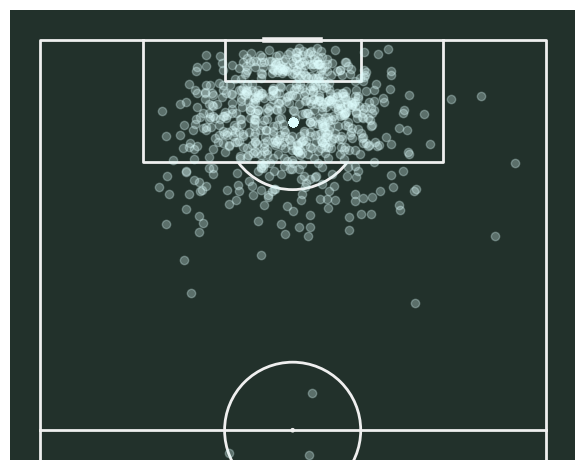

In [12]:
# Plotting where all goals came from
goals = shots.loc[shots['result'] == 'SUCCESS']
df = goals

pitch = VerticalPitch(half=True, pitch_type='impect', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw()

pitch.scatter(df.start_coordinates_x, df.start_coordinates_y,
              ax=ax, color='lightcyan', alpha=0.3, zorder=2)

plt.show()


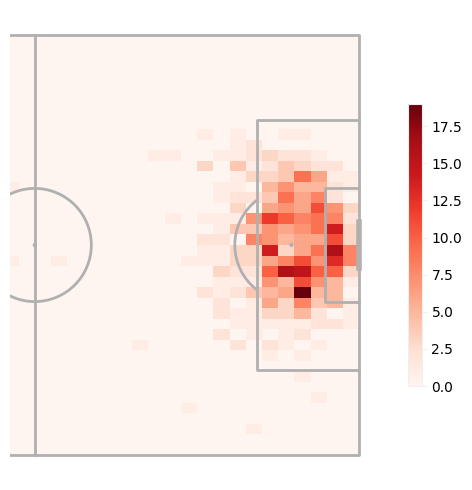

In [13]:
# Remove penalties
non_pen_gaols = goals.loc[goals['action']!='PENALTY_KICK']
df = non_pen_gaols

pitch = Pitch(half=True, pitch_type='impect', line_zorder=2)#, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(5,5))

bin_stat = pitch.bin_statistic(df['start_coordinates_x'], df['start_coordinates_y'], statistic='count', bins=(40,40))
#bin_stat['statistic'] = gaussian_filter(bin_stat['statistic'], 1)

pcm = pitch.heatmap(bin_stat, ax=ax, cmap='Reds', zorder=1) #edgecolors='#22312b')
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')

plt.tight_layout()
plt.show()

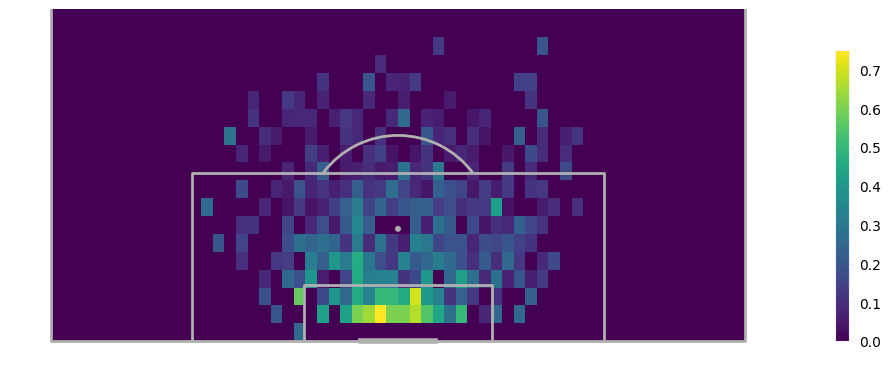

In [14]:
# Remove penalties
non_pen_goals = goals.loc[goals['action']!='PENALTY_KICK']
non_pen_shots = shots.loc[shots['action']!='PENALTY_KICK']

bins=(60,60)

pitch = VerticalPitch(half=True, pitch_type='impect', line_zorder=2, pad_bottom=-20)#, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(10,10))

goal_bin_stat = pitch.bin_statistic(non_pen_goals['start_coordinates_x'], non_pen_goals['start_coordinates_y'], statistic='count', bins=bins)
shot_bin_stat = pitch.bin_statistic(non_pen_shots['start_coordinates_x'], non_pen_shots['start_coordinates_y'],statistic='count', bins=bins)

num = goal_bin_stat['statistic'].astype(float)
denom = shot_bin_stat['statistic'].astype(float)

conversion = np.divide(
    num,
    denom,
    out=np.zeros_like(num, dtype=float),
    where=denom > 3
)

conversion = np.ma.array(conversion)#, mask=low_shot_mask)

conv_bin = goal_bin_stat.copy()
conv_bin['statistic'] = conversion

pcm = pitch.heatmap(conv_bin, ax=ax,zorder=1)
cbar = fig.colorbar(pcm, ax=ax, shrink=0.3)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')

ax.invert_xaxis()
ax.invert_yaxis()
plt.tight_layout()
plt.show()



## Predicting Goals

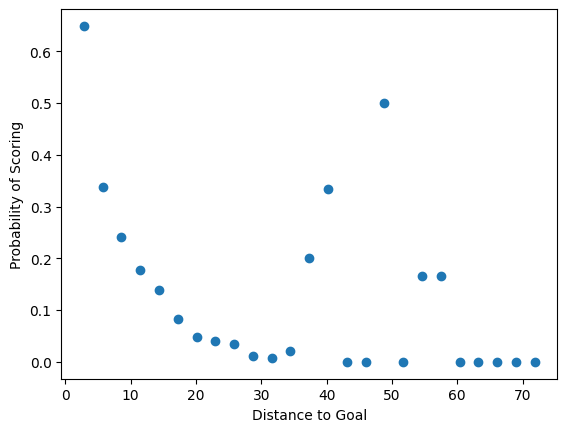

In [15]:
# Distance to goal
nbins = 25

shot_count, bin_edges = np.histogram(non_pen_shots['distanceToGoal'], bins=nbins)
goal_count, _ = np.histogram(non_pen_goals['distanceToGoal'], bins=bin_edges)
conversion_rate = np.divide(goal_count, shot_count,
                            out=np.zeros_like(goal_count, dtype=float),
                            where=shot_count > 0)

bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

fig,ax = plt.subplots()
ax.scatter(bin_centres, conversion_rate)
ax.set_xlabel('Distance to Goal')
ax.set_ylabel('Probability of Scoring')
plt.show()

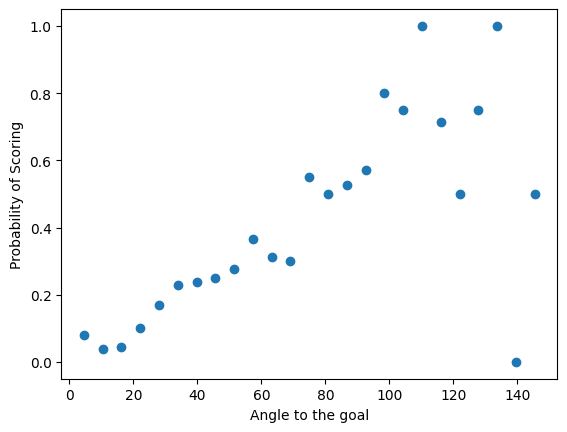

In [16]:
# Angle to goal
nbins = 25

shot_count, bin_edges = np.histogram(non_pen_shots['goal_angle'], bins=nbins)
goal_count, _ = np.histogram(non_pen_goals['goal_angle'], bins=bin_edges)
conversion_rate = np.divide(goal_count, shot_count,
                            out=np.zeros_like(goal_count, dtype=float),
                            where=shot_count > 0)

bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

fig,ax = plt.subplots()
ax.scatter(bin_centres, conversion_rate)
ax.set_xlabel('Angle to the goal')
ax.set_ylabel('Probability of Scoring')
plt.show()

## Building the xG Model

In [27]:
#non_pen_shots = non_pen_shots.copy()
non_pen_shots['is_goal'] = (non_pen_shots['result'] == 'SUCCESS').astype(int)

X = non_pen_shots[['goal_angle', 'distanceToGoal']]
y = non_pen_shots['is_goal']

model = LogisticRegression()
model.fit(X, y)

non_pen_shots['xG'] = model.predict_proba(X)[:, 1]

In [28]:
bins=(100,100)

df_bin_stat = pitch.bin_statistic(non_pen_shots['start_coordinates_x'], non_pen_shots['start_coordinates_y'], values=non_pen_shots['xG'], statistic='mean', bins=bins)

# Build arrays
X  = non_pen_shots['start_coordinates_x'].to_numpy()
Y  = non_pen_shots['start_coordinates_y'].to_numpy()
xG = non_pen_shots['xG'].to_numpy()

# Use the same grid mplsoccer created for the heatmap
Xg = df_bin_stat['x_grid']          # shape (nx, ny)
Yg = df_bin_stat['y_grid']          # shape (nx, ny)
XY_eval = np.c_[Xg.ravel(), Yg.ravel()]

# KDE bandwidth (tune: smaller = sharper, larger = smoother)
bandwidth = 1.5

# Denominator: sum K
kde_den = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde_den.fit(np.c_[X, Y], sample_weight=np.ones_like(xG))

# Numerator: sum xG * K
kde_num = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde_num.fit(np.c_[X, Y], sample_weight=xG)

# Evaluate and form the Nadaraya–Watson ratio (mean xG)
den = np.exp(kde_den.score_samples(XY_eval))
num = np.exp(kde_num.score_samples(XY_eval))
eps = 1e-12
df_bin_stat['statistic'] = (num / (den + eps)).reshape(Xg.shape)

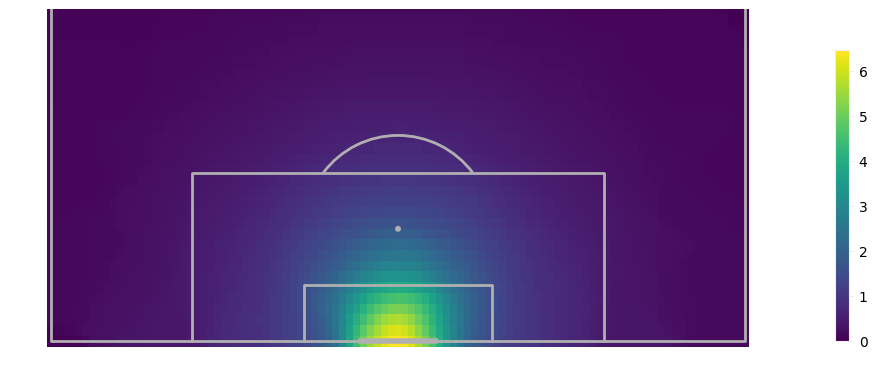

In [29]:
pitch = VerticalPitch(half=True, pitch_type='impect', line_zorder=2, pad_bottom=-20)
fig, ax = pitch.draw(figsize=(10,10))

pcm = pitch.heatmap(df_bin_stat, ax=ax, zorder=1)
cbar = fig.colorbar(pcm, ax=ax, shrink=0.3)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')

ax.invert_xaxis()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Players and Clubs xG performance

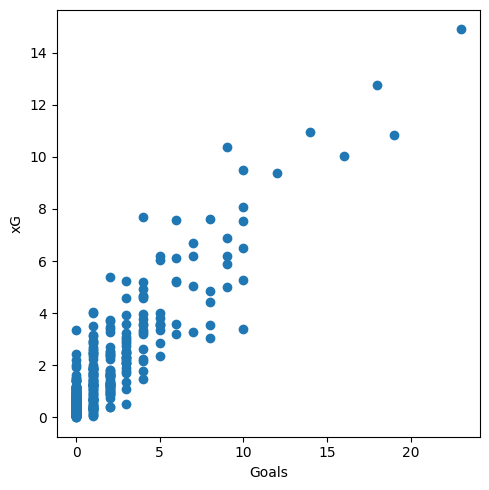

In [30]:
top_scorers = non_pen_shots[['player', 'is_goal', 'xG']].groupby(['player']).sum()

X = top_scorers['is_goal']
y = top_scorers['xG']

fig,ax = plt.subplots(figsize=(5,5))

plt.scatter(X, y)
plt.xlabel('Goals')
plt.ylabel('xG')


plt.tight_layout()
plt.show()

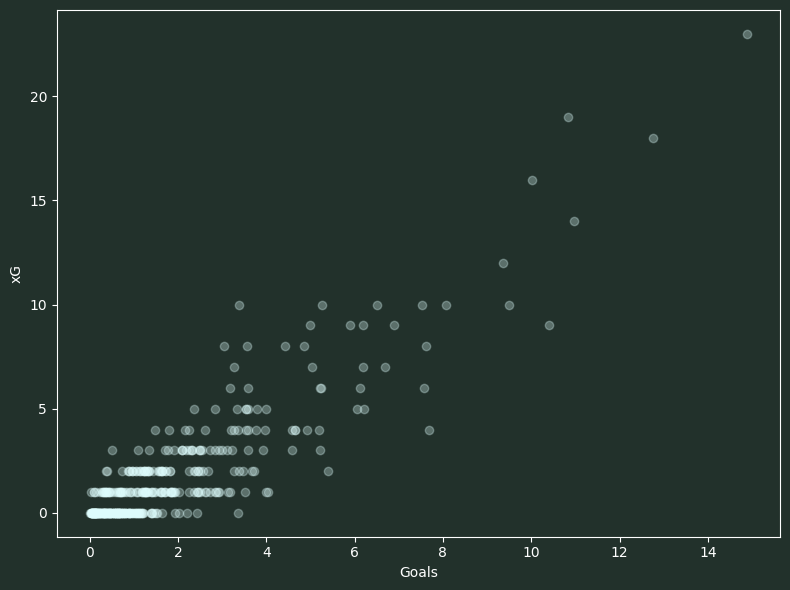

In [31]:
top_scorers_players = non_pen_shots[['player', 'is_goal', 'xG']].groupby(['player']).sum()

y = top_scorers_players['is_goal']
X = top_scorers_players['xG']

fig,ax = plt.subplots(figsize=(8,6))


pitch_color='#22312b'
line_color='#efefef'

fig.patch.set_facecolor(pitch_color)   # figure background
ax.set_facecolor(pitch_color)          # axes background

ax.scatter(X, y, color='lightcyan', alpha=0.3)
ax.set_xlabel('Goals', color='white')
ax.set_ylabel('xG', color='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('white')

plt.tight_layout()
plt.show()